<a href="https://colab.research.google.com/github/pushtiR/autoCAPTCHA/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fournierp/captcha-version-2-images")

print("Path to dataset files:", path)

100%|██████████| 17.4M/17.4M [00:01<00:00, 9.83MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fournierp/captcha-version-2-images/versions/2


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
from keras import layers
import cv2
import string
from keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory("/root/.cache/kagglehub/datasets/fournierp/captcha-version-2-images/versions/2/samples",batch_size=32,image_size=(200,50))

Found 1070 files belonging to 1 classes.


In [5]:
for images, labels in image_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 200, 50, 3)
Label batch shape: (32,)


In [6]:
image_dir = os.path.join(path, "samples")

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
print("Available Images:", image_files)

if image_files:
    image_path = os.path.join(image_dir, image_files[0])
    print("Using Image:", image_path)

Available Images: ['ncww7.png', 'mmy5n.png', 'xw465.png', 'pbpgc.png', 'e8dxn.png', '36w25.png', '6ydyp.png', 'c6745.png', '675p3.png', 'nxn4f.png', 'emwpn.png', '25257.png', 'nfcwy.png', 'bp2d4.png', 'w2yp7.png', 'bgxcd.jpg', '8nn73.png', 'mdyp7.png', 'ecd4w.png', '3nw7w.png', 'wm47f.png', 'bnc5f.png', 'p2m6n.png', 'fw3b2.png', 'nnp4e.png', 'e72cd.png', '445cc.png', 'xbem6.png', 'c2yn8.png', 'x6pdb.png', '73mnx.png', '5mcy7.png', 'm457d.png', 'n3xfg.jpg', '65nmw.jpg', 'ewcf5.png', 'nnn57.png', '8xef7.png', '6xen4.png', '6n6gg.png', 'b43nw.png', '56c34.png', '7mgmf.png', 'f85y3.png', 'f6ww8.png', 'gm7n8.png', '5n732.png', '243mm.png', '3c7de.jpg', '23mdg.png', 'nf8b8.png', '8eggg.png', '7p852.png', '43mn5.png', 'xmcym.png', '4exnn.png', 'p57fn.png', 'g8gnd.png', '7pcd7.png', 'xngxc.png', '68x48.png', '244e2.png', 'e46yw.png', 'fp382.png', 'cdmn8.png', 'dyp7n.png', '78dw6.jpg', '5mfff.png', 'x458w.png', 'm3588.png', 'n2c85.jpg', 'bgd4m.png', 'cnmnn.png', 'gfxcc.png', 'ebcbx.png', 'gp22x

In [7]:
mpimg.imread(image_path)

array([[[0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        ...,
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ],
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ],
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ]],

       [[0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        ...,
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ],
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ],
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ]],

       [[0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        [0.7529412 , 0.7529412 , 0.7529412 , 1.        ],
        ...,
        [0.9843137 , 0.9843137 , 0.9843137 , 1.        ],
        [0.9843137 , 0.984313

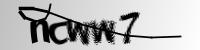

In [8]:
from IPython.display import Image as IPImage, display

# Display the image
display(IPImage(image_path))

In [9]:
print(len(image_files))

1070


In [10]:
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [11]:
##data preprocessing
##image files contain all the images
X = np.zeros((len(image_files),50,200,1))
Y = np.zeros((5,len(image_files),36))

In [12]:
print(X.shape)
print(Y.shape)

(1070, 50, 200, 1)
(5, 1070, 36)


In [13]:
def preprocess():
  for i, pic in enumerate(image_files):
    img = cv2.imread(os.path.join(image_dir,pic),cv2.IMREAD_GRAYSCALE)
    img_output = pic[:-4]

    if(len(img_output) < 6):
      if img is not None:
        img = img/255.0
        img = np.reshape(img, (50,200,1))
        target = np.zeros((5,num_symbols))
        for j, l in enumerate(img_output):
                ind = symbols.find(l)
                target[j, ind] = 1
        X[i] = img
        Y[:, i] = target
  return X ,Y
X, y = preprocess()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [14]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3 , 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3 , 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (5 , 5), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7

    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dense1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dense1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)

    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[["accuracy"] for _ in range(5)])
    return model

In [15]:
model3=create_model();
model3.summary();

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 200, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 200, 16)    │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 25, 100, 16)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 25, 100, 32)    │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 13, 50, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 13, 50, 32)     │         25,632 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 13, 50, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 7, 25, 32)      │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 5600)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)  

 Total params: 1,834,580 (7.00 MB)

 Trainable params: 1,834,516 (7.00 MB)

 Non-trainable params: 64 (256.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=6,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

output = model3.fit(
    X_train,
    [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose = 1,
    callbacks=[early_stopping]  # Pass the callback here
)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - dense_1_accuracy: 0.0409 - dense_1_loss: 3.6348 - dense_3_accuracy: 0.0523 - dense_3_loss: 3.6166 - dense_5_accuracy: 0.0553 - dense_5_loss: 3.7147 - dense_7_accuracy: 0.0466 - dense_7_loss: 3.6577 - dense_9_accuracy: 0.0618 - dense_9_loss: 3.5984 - loss: 18.2245 - val_dense_1_accuracy: 0.0515 - val_dense_1_loss: 3.5499 - val_dense_3_accuracy: 0.0928 - val_dense_3_loss: 3.5415 - val_dense_5_accuracy: 0.0619 - val_dense_5_loss: 3.5552 - val_dense_7_accuracy: 0.0464 - val_dense_7_loss: 3.5438 - val_dense_9_accuracy: 0.0412 - val_dense_9_loss: 3.5425 - val_loss: 17.7376
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - dense_1_accuracy: 0.0510 - dense_1_loss: 3.3660 - dense_3_accuracy: 0.0733 - dense_3_loss: 3.2800 - dense_5_accuracy: 0.0794 - dense_5_loss: 3.4049 - dense_7_accuracy: 0.0394 - dense_7_loss: 3.4046 - dense_9_accuracy: 0.0405 - dense_9_loss: 3.3772 - loss: 16.8326 - val_dense_1_accuracy: 0.1237 - val_dense_1_loss: 3.5

In [22]:
print(output.history.keys())

dict_keys(['dense_1_accuracy', 'dense_1_loss', 'dense_3_accuracy', 'dense_3_loss', 'dense_5_accuracy', 'dense_5_loss', 'dense_7_accuracy', 'dense_7_loss', 'dense_9_accuracy', 'dense_9_loss', 'loss', 'val_dense_1_accuracy', 'val_dense_1_loss', 'val_dense_3_accuracy', 'val_dense_3_loss', 'val_dense_5_accuracy', 'val_dense_5_loss', 'val_dense_7_accuracy', 'val_dense_7_loss', 'val_dense_9_accuracy', 'val_dense_9_loss', 'val_loss'])


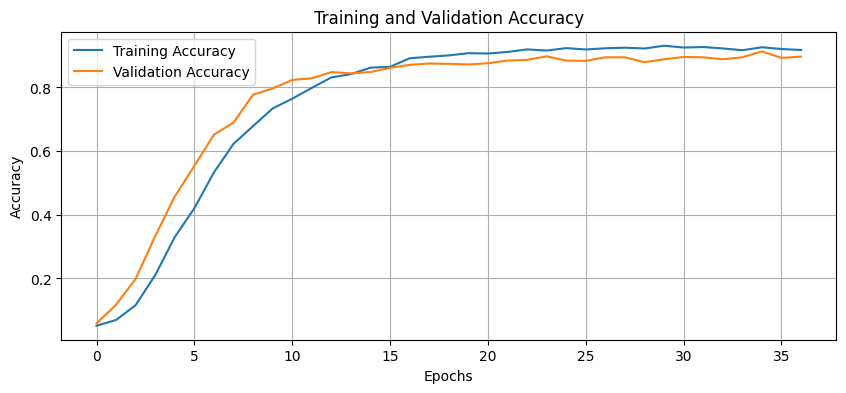

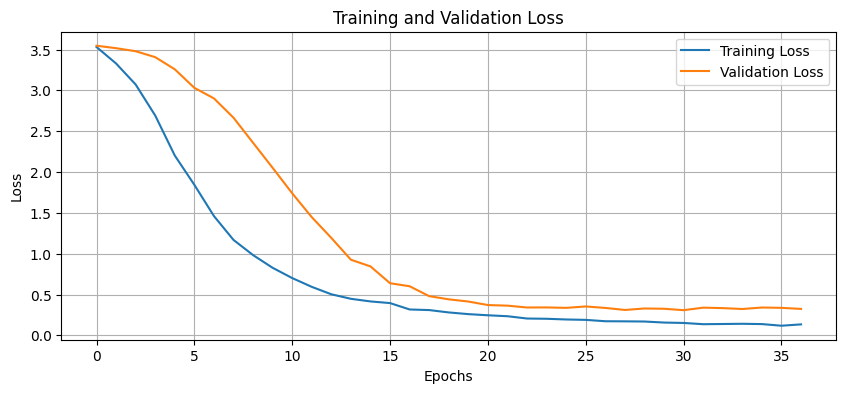

In [23]:
import numpy as np
import matplotlib.pyplot as plt

train_acc_keys = ['dense_1_accuracy', 'dense_3_accuracy' , 'dense_5_accuracy' , 'dense_7_accuracy', 'dense_9_accuracy']
val_acc_keys = ['val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy']

train_loss_keys = ['dense_1_loss', 'dense_3_loss', 'dense_5_loss' , 'dense_7_loss', 'dense_9_loss']
val_loss_keys = ['val_dense_1_loss' , 'val_dense_3_loss', 'val_dense_5_loss', 'val_dense_7_loss', 'val_dense_9_loss']

train_acc = np.mean([output.history[key] for key in train_acc_keys], axis=0)
val_acc = np.mean([output.history[key] for key in val_acc_keys] , axis=0)

train_loss =  np.mean([output.history[key] for key in train_loss_keys], axis=0)
val_loss = np.mean([output.history[key] for key in val_loss_keys] , axis=0)

# Plot Accuracy
plt.figure( figsize=( 10, 4 ))
plt.plot( train_acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize = ( 10, 4 ))
plt.plot(train_loss , label='Training Loss')
plt.plot(val_loss , label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [31]:
predictions = model3.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [32]:
#selecting the index with the highest probability
y_pred_indices = [np.argmax(pred, axis=1) for pred in predictions]
##extracting true character for each sample
y_true_indices = [np.argmax(y_test[i], axis=1) for i in range(5)]

In [33]:
#list of 5 arrays are concatenated to 1 array to perform evaluation metrics on character level
y_pred_flat = np.concatenate(y_pred_indices)
y_true_flat = np.concatenate(y_true_indices)

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_flat, y_pred_flat, average="macro")
recall = recall_score(y_true_flat, y_pred_flat, average="macro")
f1 = f1_score(y_true_flat, y_pred_flat, average="macro")

print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1:.2%}")

Precision: 92.71%
Recall: 91.74%
F1-score: 91.98%
